In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Change this path to where your ZIP file is stored in Drive
zip_path = '/content/drive/MyDrive/v43hmbwxpm-2.zip'
extract_path = '/content/bearing_data'  # Temporary working directory

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted successfully.")


✅ Dataset extracted successfully.


In [ ]:
# List the folders
for folder in os.listdir(extract_path):
    print(folder)


5 Data collected from a bearing with a combination of faults
1 Data collected from a healthy bearing
4 Data collected from a bearing with ball fault
2 Data collected from a bearing with inner race fault
3 Data collected from a bearing with outer race fault


In [ ]:
import scipy.io as sio
import numpy as np

# Map folder names to class labels
folder_labels = {
    '1 Data collected from a healthy bearing': 0,
    '2 Data collected from a bearing with inner race fault': 1,
    '3 Data collected from a bearing with outer race fault': 2,
    '4 Data collected from a bearing with ball fault': 3,
    '5 Data collected from a bearing with a combination of faults': 4
}

# Initialize lists
all_signals = []
all_labels = []

# Loop through folders and load signals
for folder, label in folder_labels.items():
    folder_path = os.path.join(extract_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.mat'):
            mat = sio.loadmat(os.path.join(folder_path, file))
            signal = mat['Channel_1'].flatten()  # Vibration signal
            all_signals.append(signal)
            all_labels.append(label)

print(f"✅ Loaded {len(all_signals)} vibration signals.")


✅ Loaded 60 vibration signals.


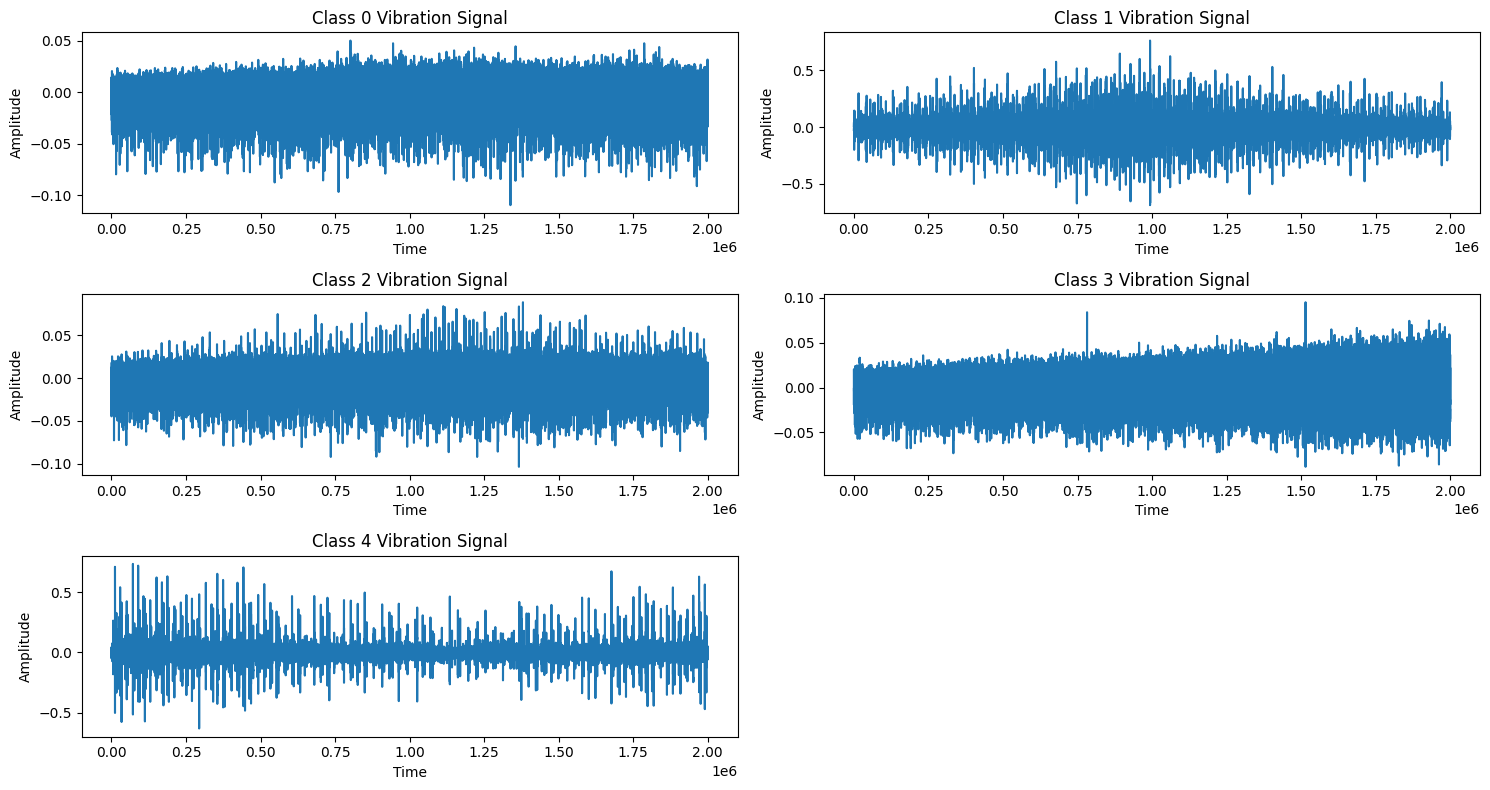

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for i in range(5):
    idx = all_labels.index(i)  # Get first signal for each class
    plt.subplot(3, 2, i+1)
    plt.plot(all_signals[idx])
    plt.title(f'Class {i} Vibration Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [ ]:
window_size = 15000
step_size = 10000

segmented_signals = []
segmented_labels = []

for signal, label in zip(all_signals, all_labels):
    for start in range(0, len(signal) - window_size, step_size):
        end = start + window_size
        segment = signal[start:end]
        segmented_signals.append(segment)
        segmented_labels.append(label)

print(f"✅ Total Segments Created: {len(segmented_signals)}")


✅ Total Segments Created: 11940


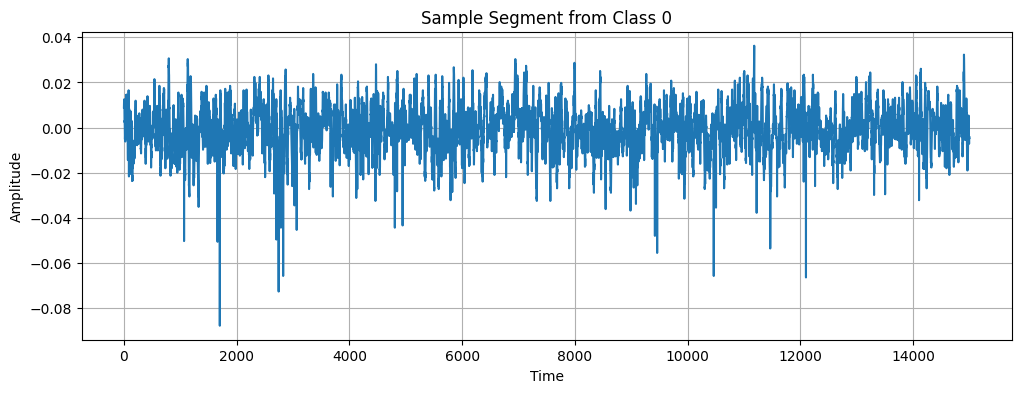

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(segmented_signals[0])
plt.title(f"Sample Segment from Class {segmented_labels[0]}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
def add_awgn_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

# Apply noise to all segments
snr_db = 5  # You can change this to 10 or 0 later
noisy_segments = [add_awgn_noise(seg, snr_db) for seg in segmented_signals]

print("✅ Noise added to all segments.")


✅ Noise added to all segments.


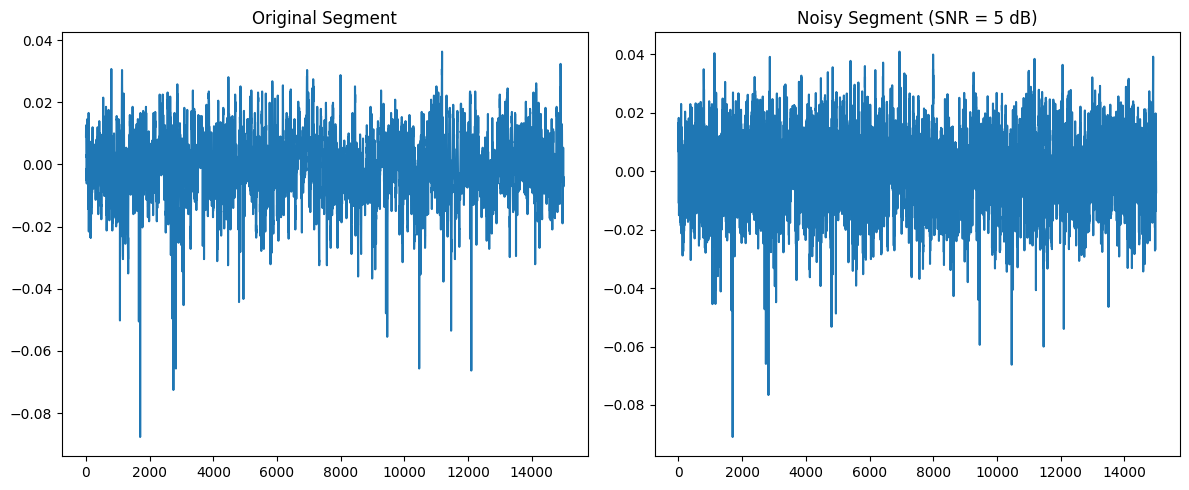

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(segmented_signals[0])
plt.title("Original Segment")

plt.subplot(1, 2, 2)
plt.plot(noisy_segments[0])
plt.title(f"Noisy Segment (SNR = {snr_db} dB)")

plt.tight_layout()
plt.show()

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.5 MB/s eta 0:00:00


In [ ]:
import pywt

def wavelet_denoise(signal, wavelet='sym8', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Universal thresholding
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))

    # Hard thresholding
    coeffs_thresh = [pywt.threshold(c, value=uthresh, mode='hard') if i != 0 else c for i, c in enumerate(coeffs)]

    # Reconstruct the signal
    return pywt.waverec(coeffs_thresh, wavelet)

# Denoise all segments
denoised_segments = [wavelet_denoise(sig) for sig in noisy_segments]
print("✅ Wavelet denoising applied to all segments.")


✅ Wavelet denoising applied to all segments.


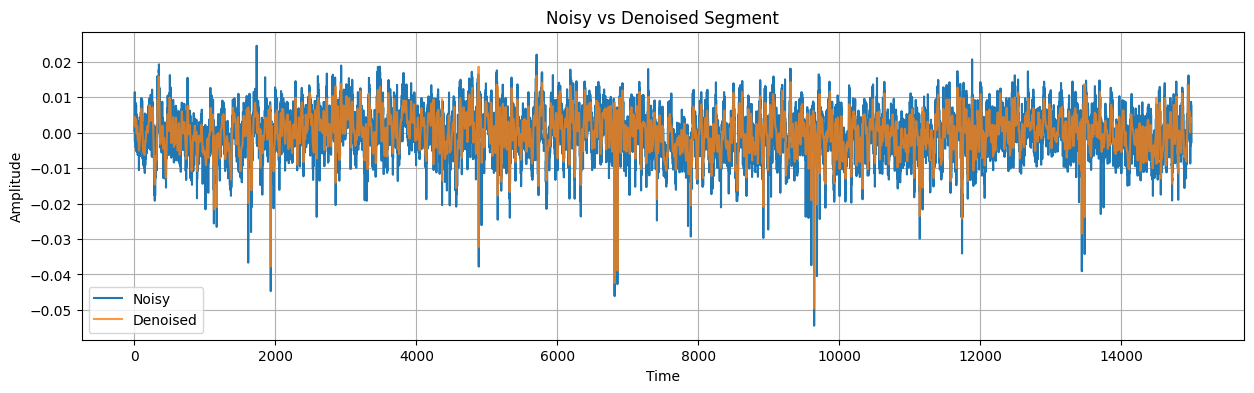

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(noisy_segments[0], label='Noisy')
plt.plot(denoised_segments[0], label='Denoised', alpha=0.8)
plt.title("Noisy vs Denoised Segment")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

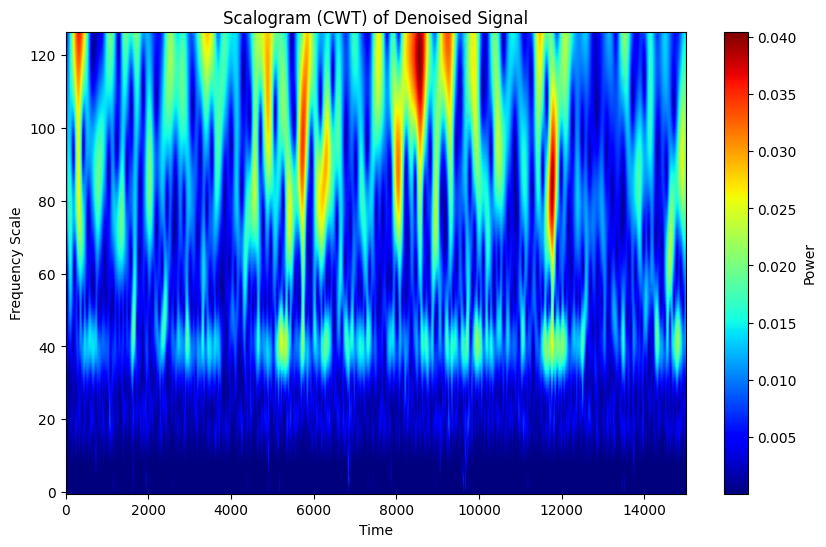

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

def generate_scalogram(signal, widths=np.arange(1, 128)):
    # Use continuous wavelet transform with complex Morlet wavelet
    coef, freqs = pywt.cwt(signal, widths, 'cmor1.5-1.0')  # Morlet wavelet
    power = np.abs(coef)

    return power

# Example: plot one
scalo = generate_scalogram(denoised_segments[0])

plt.figure(figsize=(10, 6))
plt.imshow(scalo, aspect='auto', cmap='jet', origin='lower')
plt.title("Scalogram (CWT) of Denoised Signal")
plt.xlabel("Time")
plt.ylabel("Frequency Scale")
plt.colorbar(label='Power')
plt.show()


In [ ]:

import numpy as np
import cv2
from tqdm import tqdm


In [ ]:
def generate_scalogram(signal, widths=np.arange(1, 128)):
    coef, _ = pywt.cwt(signal, widths, 'cmor1.5-1.0')
    power = np.abs(coef)
    return power

def convert_to_image(scalogram, size=(224, 224)):
    scalo_norm = (scalogram - np.min(scalogram)) / (np.max(scalogram) - np.min(scalogram))
    scalo_resized = cv2.resize(scalo_norm, size)
    scalo_rgb = np.stack([scalo_resized]*3, axis=-1)  # Make it 3-channel
    return (scalo_rgb * 255).astype(np.uint8)


In [ ]:
cnn_images = []
cnn_labels = []

for sig, label in tqdm(zip(denoised_segments, segmented_labels), total=len(denoised_segments)):
    scalo = generate_scalogram(sig)
    img = convert_to_image(scalo)
    cnn_images.append(img)
    cnn_labels.append(label)

cnn_images = np.array(cnn_images)
cnn_labels = np.array(cnn_labels)

print("✅ All scalograms generated and converted to arrays.")
print("Images shape:", cnn_images.shape)
print("Labels shape:", cnn_labels.shape)


100%|██████████| 11940/11940 [3:47:17<00:00,  1.14s/it]


✅ All scalograms generated and converted to arrays.
Images shape: (11940, 224, 224, 3)
Labels shape: (11940,)


In [ ]:
import numpy as np

data = np.load('/content/drive/MyDrive/Bearing_Project/PARTIAL_cnn_scalograms_22percent.npz')
cnn_images = data['images']
cnn_labels = data['labels']

print("✅ Data loaded:")
print("Images shape:", cnn_images.shape)
print("Labels shape:", cnn_labels.shape)


✅ Data loaded:
Images shape: (2717, 224, 224, 3)
Labels shape: (2717,)


In [ ]:
# Convert lists to arrays
total_images = np.array(cnn_images)
total_labels = np.array(cnn_labels)

# Save to npz file
np.savez('/content/drive/MyDrive/Bearing_Project/PARTIAL_cnn_scalograms_22percent.npz',
         images=total_images,
         labels=total_labels)

print(f"✅ Saved {len(total_images)} scalograms to Drive.")


✅ Saved 2717 scalograms to Drive.


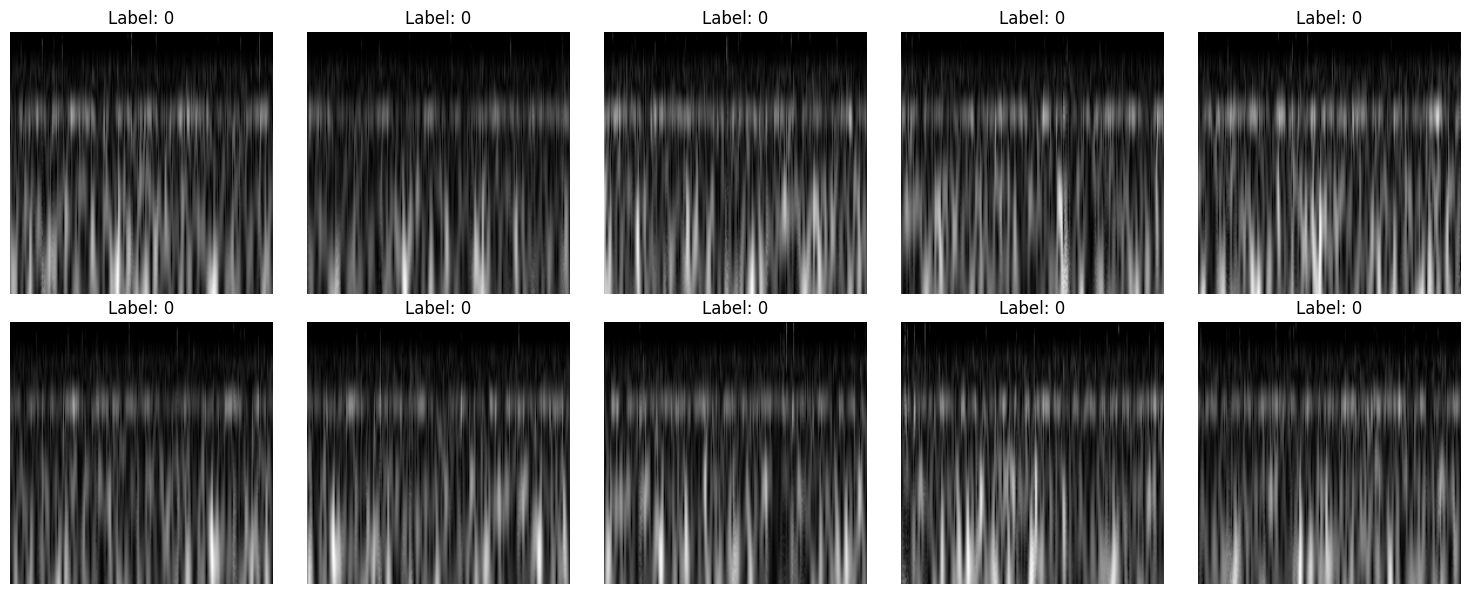

In [ ]:
import matplotlib.pyplot as plt

# Plot the first 10 scalograms
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cnn_images[i])
    plt.title(f"Label: {cnn_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import gc

gc.collect()

30121

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Normalize images
cnn_images = cnn_images.astype('float32') / 255.0

# One-hot encode labels (5 classes)
num_classes = len(np.unique(cnn_labels))
cnn_labels_cat = to_categorical(cnn_labels, num_classes)

# Split dataset: 70% train, 20% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(cnn_images, cnn_labels_cat, test_size=0.3, random_state=42, stratify=cnn_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

print("✅ Data split complete:")
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


✅ Data split complete:
Train: (1901, 224, 224, 3)
Val: (544, 224, 224, 3)
Test: (272, 224, 224, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)

model = Sequential()

# Conv Block 1
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Conv Block 2
model.add(Conv2D(256, (5, 5), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Conv Block 3
model.add(Conv2D(384, (3, 3), padding="same", activation='relu'))

# Conv Block 4
model.add(Conv2D(384, (3, 3), padding="same", activation='relu'))

# Conv Block 5
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# FC Layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,756,610 (178.36 MB)

 Trainable params: 46,755,906 (178.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler

# Load the data from the .npz file
data = np.load('/content/drive/MyDrive/Bearing_Project/PARTIAL_cnn_scalograms_22percent.npz')
cnn_images = data['images']
cnn_labels = data['labels']

# Normalize images
cnn_images = cnn_images.astype('float32') / 255.0

# Reshape images for RandomUnderSampler
cnn_images_reshaped = cnn_images.reshape(cnn_images.shape[0], -1)

# One-hot encode labels (5 classes)
num_classes = len(np.unique(cnn_labels))
cnn_labels_cat = to_categorical(cnn_labels, num_classes)

# Apply RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(cnn_images_reshaped, cnn_labels)

# Reshape images back to original shape
X_resampled = X_resampled.reshape(X_resampled.shape[0], cnn_images.shape[1], cnn_images.shape[2], cnn_images.shape[3])

# One-hot encode resampled labels
y_resampled_cat = to_categorical(y_resampled, num_classes)

# Split dataset: 70% train, 20% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled_cat, test_size=0.3, random_state=42, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

print("✅ Data split complete:")
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

✅ Data split complete:
Train: (460, 224, 224, 3)
Val: (132, 224, 224, 3)
Test: (66, 224, 224, 3)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,  # You can increase this later
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.6674 - loss: 29.2242 - val_accuracy: 0.8030 - val_loss: 0.4353
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.9037 - loss: 0.8023 - val_accuracy: 0.5379 - val_loss: 0.6017
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.9891 - loss: 0.0309 - val_accuracy: 0.7121 - val_loss: 0.4048
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.5530 - val_loss: 0.6933
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 1.0000 - loss: 2.6436e-04 - val_accuracy: 0.6591 - val_loss: 0.5166
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 1.0000 - loss: 1.2578e-04 - val_accuracy: 0.8182 - val_loss: 0.2821
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.9951 - loss: 0.0164 - val_accuracy: 0.8258 - val_loss: 0.2537
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 1.0000 - loss: 6.6129e-08 - val_accuracy: 0.939

In [ ]:
import random
import numpy as np

# Assuming you have the scalogram data loaded already:
data = np.load('/content/drive/MyDrive/Bearing_Project/PARTIAL_cnn_scalograms_22percent.npz')
cnn_images = data['images']
cnn_labels = data['labels']

# ... (Other parts of your code to generate segmented_signals and segmented_labels) ...

# Step 1: Pick a random test signal from your dataset
rand_index = random.randint(0, len(segmented_signals) - 1)
new_signal = segmented_signals[rand_index]
true_label = segmented_labels[rand_index]

print(f"🔍 Simulating prediction on segment #{rand_index} (True label: {true_label})")

🔍 Simulating prediction on segment #6398 (True label: 2)


In [ ]:
!pip install opencv-python

In [ ]:
import cv2 # Import cv2
# Denoise
denoised_new = wavelet_denoise(new_signal)

# Scalogram
scalo = generate_scalogram(denoised_new)

# Convert to image
img = convert_to_image(scalo)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)  # (1, 224, 224, 3)

# Predict
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Map and print
class_names = {
    0: "Healthy",
    1: "Inner Race Fault",
    2: "Outer Race Fault",
    3: "Ball Fault",
    4: "Combined Fault"
}

print(f"✅ Predicted Class: {predicted_class} ({class_names[predicted_class]})")
print(f"🎯 Actual Class:    {true_label} ({class_names[true_label]})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
✅ Predicted Class: 1 (Inner Race Fault)
🎯 Actual Class:    2 (Outer Race Fault)


In [ ]:
# Ask user to enter an index number
index = int(input(f"Enter a segment number (0 to 2717): "))

# Fetch the signal and true label
new_signal = segmented_signals[index]
true_label = segmented_labels[index]

# Denoise
denoised_new = wavelet_denoise(new_signal)

# Scalogram
scalo = generate_scalogram(denoised_new)

# Convert to image
img = convert_to_image(scalo)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

# Predict
prediction = model.predict(img)
predicted_class = np.argmax(prediction)

# Class name map
class_names = {
    0: "Healthy",
    1: "Inner Race Fault",
    2: "Outer Race Fault",
    3: "Ball Fault",
    4: "Combined Fault"
}

# Output result
print(f"\n✅ Predicted Class: {predicted_class} ({class_names[predicted_class]})")
print(f"🎯 Actual Class:    {true_label} ({class_names[true_label]})")


Enter a segment number (0 to 2717): 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

✅ Predicted Class: 0 (Healthy)
🎯 Actual Class:    0 (Healthy)


.

.

.

.

.

.


.


.


.


.


.



.



.



.



.


.


.

.
.
.


.
..



...
.


.




.....
